# CRM 애널리틱스: 이커머스 판매 데이타

## < 프로젝트 소개 >
온라인몰의 판매 데이터를 통해 RFM, 코호트, 세그멘테이션, 고객 생애 가지 분석을 실시한다. 해당 온라인몰은 유럽을 기반으로 영국을 주된 시장을 하여 다양한 생활용품들을 판매하는 회사이다.


## < 데이터파일 >
- data.csv (대용량 파일로 첨부하지 않음: 45.6MB)

## < 데이타 필드 >
- InvoiceNo: 인보이스 번호로 숫자 6자로 되어 있음. 취소된 주문이면 번호앞에 C로 시작된다.
- StockCode: 제품번호로 숫자5자리로 이뤄져 있다.
- Description: 제품 이름
- Quantity: 주문당 제품의 갯수
- InvoiceDate: 주문이 이뤄진 날짜와 시간
- UnitPrice: 제품 개당 가격
- CustomerID: 고객마다 특정한 고객 ID가지고 있으면 이 숫자는 5개의 숫자로 이뤄져 있다.
- Country: 고객이 거주하고 있는 국가 이름

## < 분석 방법 >
- RFM Analysis
- Cohort Analysis
- Segmentation Anlysis
- Customer Lifetime Value

## < 목차 >
1. Libraries and Utillities
2. Load and Check data
3. Undestand Data
4. Data Preprocessing
5. RFM Analysis
6. Cohort Analysis
7. Customer Lifetime Value

### 참고
https://www.kaggle.com/code/sercanyesiloz/crm-analytics/notebook



# 1. Libraries and Utilities

In [1]:
!pip install Lifetimes

In [2]:
import os
import squarify
import warnings
import numpy as np
import pandas as pd
import datetime as dt
from operator import attrgetter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

%matplotlib inline
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
palette = "Set2"

# 2. Load and Check Data

InvoiceNo, CustomerID, InvoiceDate의 데이타 타입을 바꿔준다.

In [3]:
df = pd.read_csv(
    "data.csv",
    header=0,
    encoding="unicode_escape",
    dtype={"CustomerID": str, "InvoiceNo": str},
    parse_dates=["InvoiceDate"],
    infer_datetime_format=True,
)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


# 3. Understand Data

데이타의 구조와 누락된 값이 있는지 알아 본다.

In [5]:
def check_data(dataframe, head=5):
    print(" SHAPE ".center(70, "-"))
    print("Rows: {}".format(dataframe.shape[0]))
    print("Columns: {}".format(dataframe.shape[1]))
    print(" TYPES ".center(70, "-"))
    print(dataframe.dtypes)
    print(" HEAD ".center(70, "-"))
    print(dataframe.head(head))
    print(" TAIL ".center(70, "-"))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70, "-"))
    print(dataframe.isnull().sum())
    print(" DUPLIACATED VALUES ".center(70, "-"))
    print(dataframe.duplicated().sum())
    print(" DESCRIPTIVE STATSTICS ".center(70, "-"))
    print(dataframe.describe([0, 0.01, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_data(df)

------------------------------- SHAPE --------------------------------
Rows: 541909
Columns: 8
------------------------------- TYPES --------------------------------
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object
-------------------------------- HEAD --------------------------------
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 0

#### 짚고가야 할 점들
- Quantity, UnitPrice 열에 이상치가 있다.
- Quantity and UnitPrice 열에 취소된 주문으로 인해 마이너스 값이 있다.
- 또한 Description, CustomerID 열에 누락된 값이 있다.
- Quantity, UnitPrice 열을 곱해 새로운 TotalPrice 열을 만든다.

# 4. Data Preprocessing

Here, we'll create a new column of TotalPrice and remove outliers with the IQR method.

In [6]:
# IQR 방법을 이용해 이상치를 제거하는 함수를 만든다.
# quartile의 값을 0.01과 0.99로 설정한다.

def replace_with_threshold(dataframe, variable):
    df_ = dataframe.copy()
    quartile1 = df_[variable].quantile(0.01)
    quartile3 = df_[variable].quantile(0.99)
    IQR = quartile3 - quartile1

    up_limit = quartile3 + IQR * 1.5
    low_limit = quartile1 - IQR * 1.5
    df_.loc[(df_[variable] < low_limit), variable] = low_limit
    df_.loc[(df_[variable] > up_limit), variable] = up_limit

    return df_


def ecommerce_preprocess(dataframe):
    df_ = dataframe.copy()

    # 누락된 값이 있는 행은 삭제한다.
    df_ = df_.dropna()

    # 취소된 주문이 있는 행도 삭제한다.
    df_ = df_[~df_["InvoiceNo"].str.contains("C", na=False)]
    df_ = df_[df_["Quantity"] > 0]

    # 이상치를 삭제한다.
    df_ = replace_with_threshold(df_, "Quantity")
    df_ = replace_with_threshold(df_, "UnitPrice")

    # TotalPrice 열을 새로 만든다
    df_["TotalPrice"] = df_["Quantity"] * df_["UnitPrice"]

    return df_


df = ecommerce_preprocess(df)

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [8]:
df.describe([0, 0.01, 0.05, 0.50, 0.95, 0.99, 1]).T

,count,mean,std,min,0%,1%,5%,50%,95%,99%,100%,max
Quantity,397924.0,11.833736,25.534512,1.0,1.0,1.00,1.00,6.00,36.0,120.00,298.500,298.500
UnitPrice,397924.0,2.893163,3.227059,0.0,0.0,0.21,0.42,1.95,8.5,14.95,37.060,37.060
TotalPrice,397924.0,20.627751,51.826400,0.0,0.0,0.55,1.25,11.80,67.5,183.60,3268.575,3268.575


# 5. RFM Analysis

RFM은 Recency, Frequency, Monetary를 의미하며 고객의 중요한 특성을 나타낸다. RFM은 고객의 중요한 행동을 측정하는 기준이 된다. monetary value는 생애 고객 가치값에, recency는 리텐션과 고객의 활동성에 영향을 준다.

## 5.1 RFM Metrics

In [9]:
# InvoiceDate 열에서 가장 최근으 날짜를 확인한다.

print(df.InvoiceDate.max())

2011-12-09 12:50:00


In [10]:
# recency 계산을 위해 오늘의 날짜를 여기에 2일 더하여 설정한다.

today_date = dt.datetime(2011, 12, 11)
today_date

datetime.datetime(2011, 12, 11, 0, 0)

In [11]:
# 각 고객의 receny, frequency, monetary value값을 계산한다.

rfm = df.groupby("CustomerID").agg(
    {
        "InvoiceDate": lambda x: (today_date - x.max()).days,
        "InvoiceNo": lambda x: x.nunique(),
        "TotalPrice": lambda x: x.sum(),
    }
)

# 열의 이름을 다시 설정
rfm.columns = ["recency", "frequency", "monetary"]

# 인덱스도 재설정 한다
rfm = rfm.reset_index()

# monetary 열에서 마이너스 값을 없애준다.
def remove_negative_monetary(dataframe):
    if dataframe["monetary"].any() <= 0:
        dataframe[datatframe["monetary"] > 0] = dataframe
    else:
        dataframe

    return dataframe


rfm = remove_negative_monetary(rfm)
rfm.head()

,CustomerID,recency,frequency,monetary
0,12346,326,1,310.44
1,12347,3,7,4310.00
2,12348,76,4,1770.78
3,12349,19,1,1491.72
4,12350,311,1,331.46


## 5.2 RFM Scores

In [12]:
rfm.frequency.rank(method="first", ascending=False)

0       2846.0
1        558.0
2       1116.0
3       2847.0
4       2848.0
         ...  
4334    4338.0
4335    4339.0
4336    2845.0
4337     162.0
4338    2010.0
Name: frequency, Length: 4339, dtype: float64

In [13]:
# RFM score를 아래와 같이 설정한다.
# RFM 값을 5개의 그룹으로 나누고 각각의 값에 1-5사이의 점수를 부여한다.

def get_rfm_scores(dataframe):
    df_ = dataframe.copy()
    df_["recency_score"] = pd.qcut(df_["recency"], 5, labels=[5, 4, 3, 2, 1])
    df_["frequency_score"] = pd.qcut(
        df_["frequency"].rank(method="first", ascending=False),
        5,
        labels=[5, 4, 3, 2, 1],
    )
    df_["monetary_score"] = pd.qcut(df_["monetary"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFM_SCORE"] = df_["recency_score"].astype(str) + df_["frequency_score"].astype(
        str
    )

    return df_


rfm = get_rfm_scores(rfm)
rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,12346,326,1,310.44,1,2,2,12
1,12347,3,7,4310.00,5,5,5,55
2,12348,76,4,1770.78,2,4,4,24
3,12349,19,1,1491.72,4,2,4,42
4,12350,311,1,331.46,1,2,2,12


## 5.3 Segmentation

고객을 10개의 그룹으로 세분화하여 나누고 그에 따른 RFM 점수를 부여하며, 이 RFM 점수에는 우선 recency, frequency 요소만 고려하며 monetary는 이 프로젝트의 아중에 고객 생애 가치 계산에 사용한다.

In [14]:
# 아래는 세그멘테이션을 맵핑하는 방법이다.
seg_map = {
    r"[1-2][1-2]": "hibernating",
    r"[1-2][3-4]": "at_risk",
    r"[1-2]5": "cant_loose",
    r"3[1-2]": "about_to_sleep",
    r"33": "need_attention",
    r"[3-4][4-5]": "loyal_customers",
    r"41": "promising",
    r"51": "new_customers",
    r"[4-5][2-3]": "potential_loyalists",
    r"5[4-5]": "champions",
}
rfm["segment"] = rfm["RFM_SCORE"].replace(seg_map, regex=True)
rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346,326,1,310.44,1,2,2,12,hibernating
1,12347,3,7,4310.00,5,5,5,55,champions
2,12348,76,4,1770.78,2,4,4,24,at_risk
3,12349,19,1,1491.72,4,2,4,42,potential_loyalists
4,12350,311,1,331.46,1,2,2,12,hibernating


## 5.4 Segment Analysis

In [15]:
# 각각의 세그먼트의 descriptive statistics을 살펴보자.

rfm_stats = rfm.groupby("segment")[["recency", "frequency", "monetary"]].agg(
    ["mean", "std", "min", "max"]
)
rfm_stats.index = seg_map.values()
rfm_stats

recency                      frequency                 \
                           mean        std min  max       mean        std min   
hibernating           52.829912  10.859007  34   72   1.134897   0.342116   1   
at_risk              154.833333  70.144213  73  374   2.886054   0.955006   2   
cant_loose           131.396825  65.462508  73  373   8.380952   4.289630   6   
about_to_sleep         6.436137   3.692528   1   13  12.285047  16.397882   3   
need_attention       216.828067  91.689553  73  374   1.105948   0.307914   1   
loyal_customers       34.068702  15.875964  15   72   6.625954   4.582719   3   
promising             52.144231  11.617011  34   72   2.341346   0.475305   2   
new_customers          8.027778   3.525305   2   13   1.000000   0.000000   1   
potential_loyalists   17.131313   9.146852   1   33   2.044444   0.659748   1   
champions             24.423077   5.522579  15   33   1.000000   0.000000   1   

                             monetary                                    
                     max         mean           std     min         max  
hibernating            2   435.294267    527.698848    6.20    6207.670  
at_risk                6  1003.515990   1037.528490   52.00   11072.670  
cant_loose            34  2644.023492   2008.480363   70.02   10254.180  
about_to_sleep       210  6425.777407  18245.695493  102.45  266163.525  
need_attention         2   365.693732    409.269166    3.75    4729.990  
loyal_customers       63  2853.629378   5497.363932   36.56  120210.355  
promising              3   809.498750    625.321921    6.90    4932.200  
new_customers          1   318.917639    235.462758   41.99    1201.490  
potential_loyalists    3   662.319455    640.849920    0.00    7005.360  
champions              1   324.112548    318.301832   20.80    2328.840

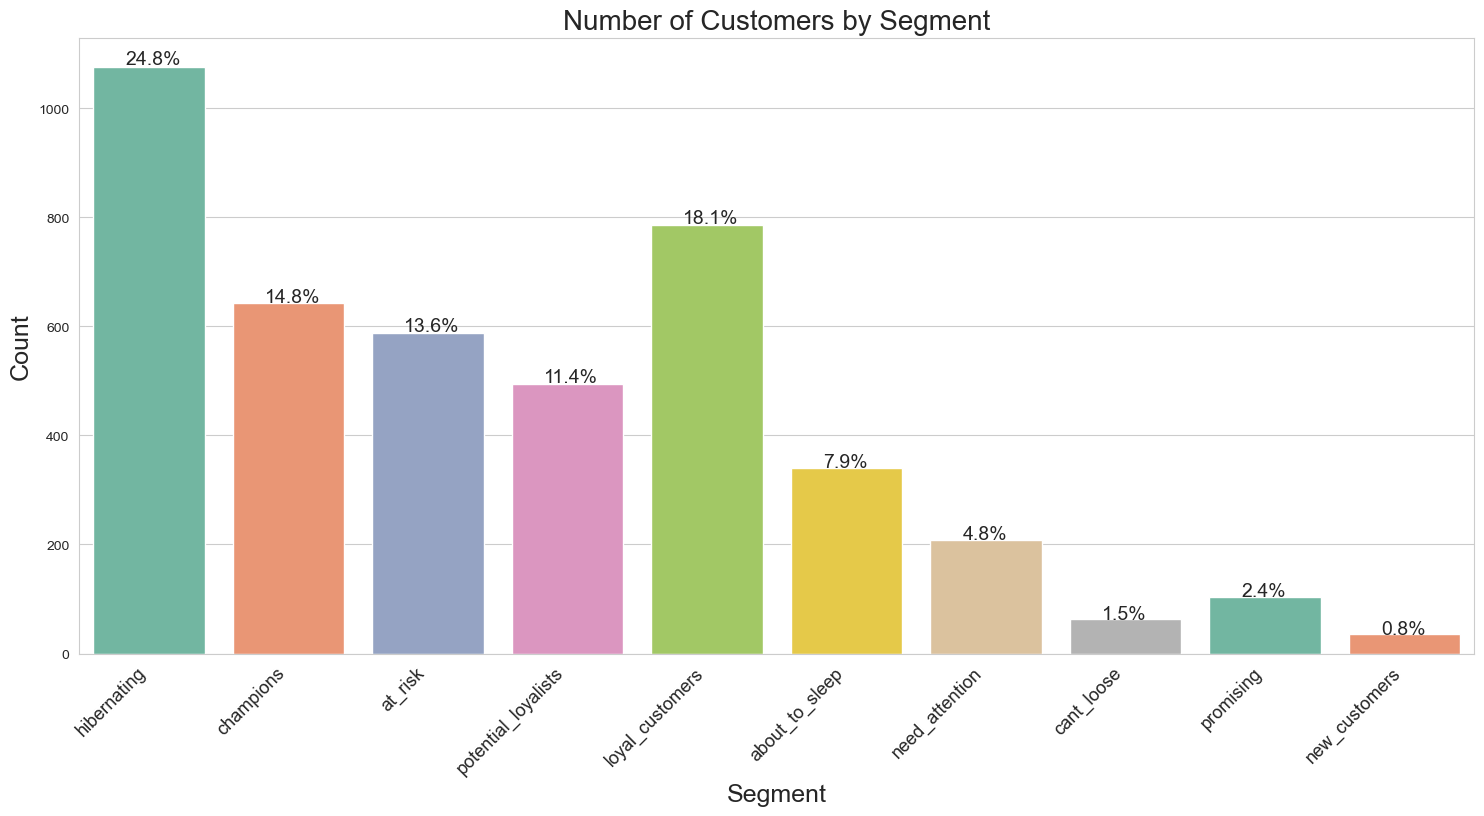

In [28]:
# 세그먼트의 카운트플롯을 해본다.

plt.figure(figsize=(18, 8))
ax = sns.countplot(data=rfm, x="segment", palette=palette)

total = len(rfm)
for patch in ax.patches:
    percentage = "{:.1f}%".format(patch.get_height() / total * 100)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size=14)
plt.title("Number of Customers by Segment", size=20)
plt.xlabel("Segment", size=18)
plt.ylabel("Count", size=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", size=13)
plt.show()

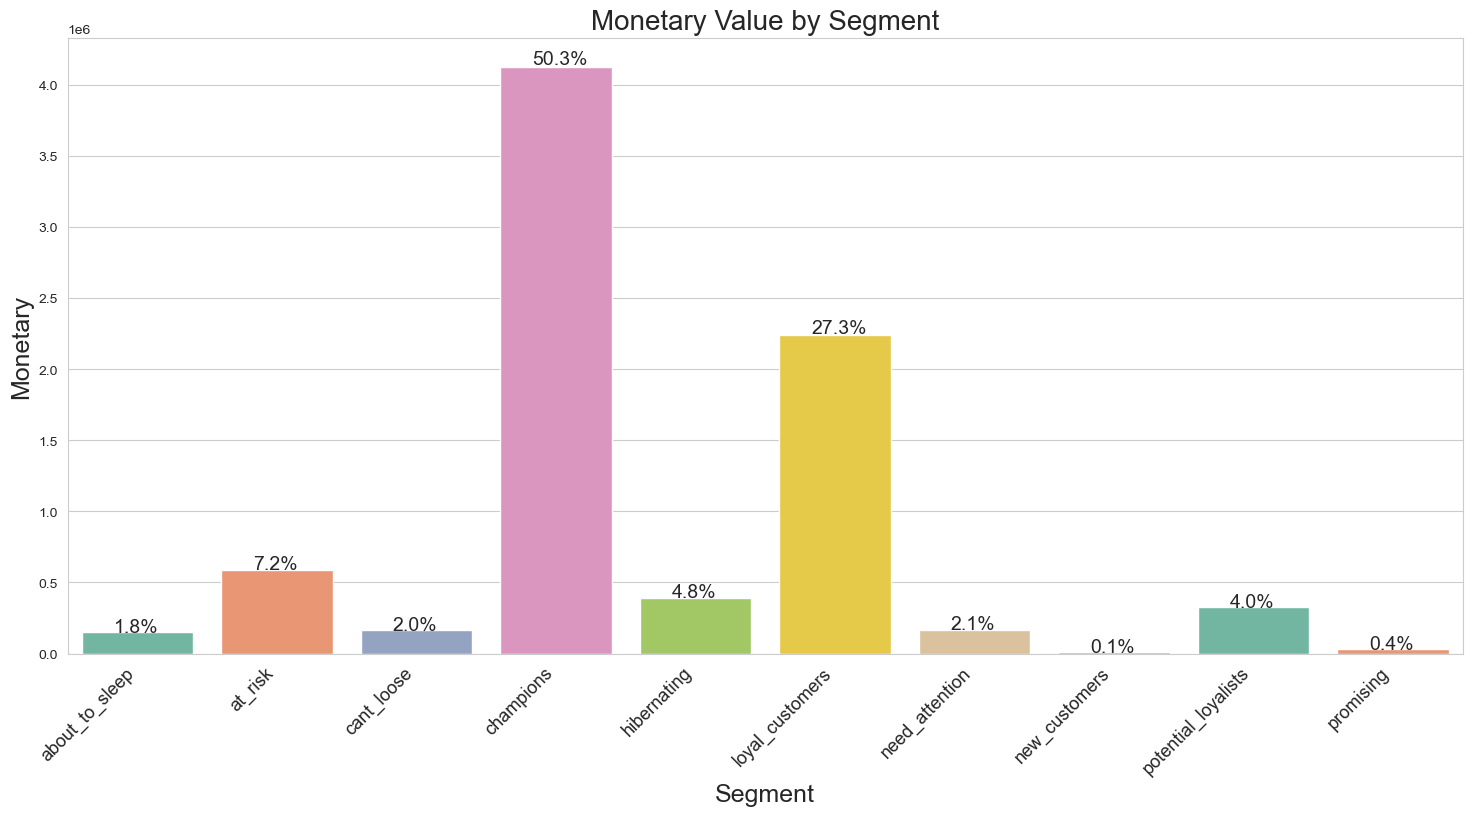

In [29]:
# 또한 세그먼트 별 매출액 플롯을 그려본다.

# First of all, create a pivot table
rfm_rev = rfm.groupby("segment")[["monetary"]].agg("sum").reset_index()

# Code a bar plot
plt.figure(figsize=(18, 8))
ax2 = sns.barplot(data=rfm_rev, x="segment", y="monetary", palette=palette)

total_rev = rfm_rev.monetary.sum()
for patch in ax2.patches:
    percentage = "{:.1f}%".format(patch.get_height() / total_rev * 100)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax2.annotate(percentage, (x, y), size=14)
plt.title("Monetary Value by Segment", size=20)
plt.xlabel("Segment", size=18)
plt.ylabel("Monetary", size=18)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right", size=13)
plt.show()

- 온라인몰의 중요한 고객군은 champions, loyal customers, potential loyalists으로 이 세 그룹은 전체 고객의 44.3%을 차지하는데 매출에 있어서는 81.6%를 내고 있으며 이에 반면 ibernating, at-risk, about-to-sleep 그룹은 전체 고객의 46.3%을 차지하지만 매출에 있어서는 13.8%밖에 차지하지 않는 것을 알 수 있다. 특히 champions 고객은 저첸의 14.8% 밖에 차지하지 않지만 전체 매출의 반이상을 차지하고 있다.

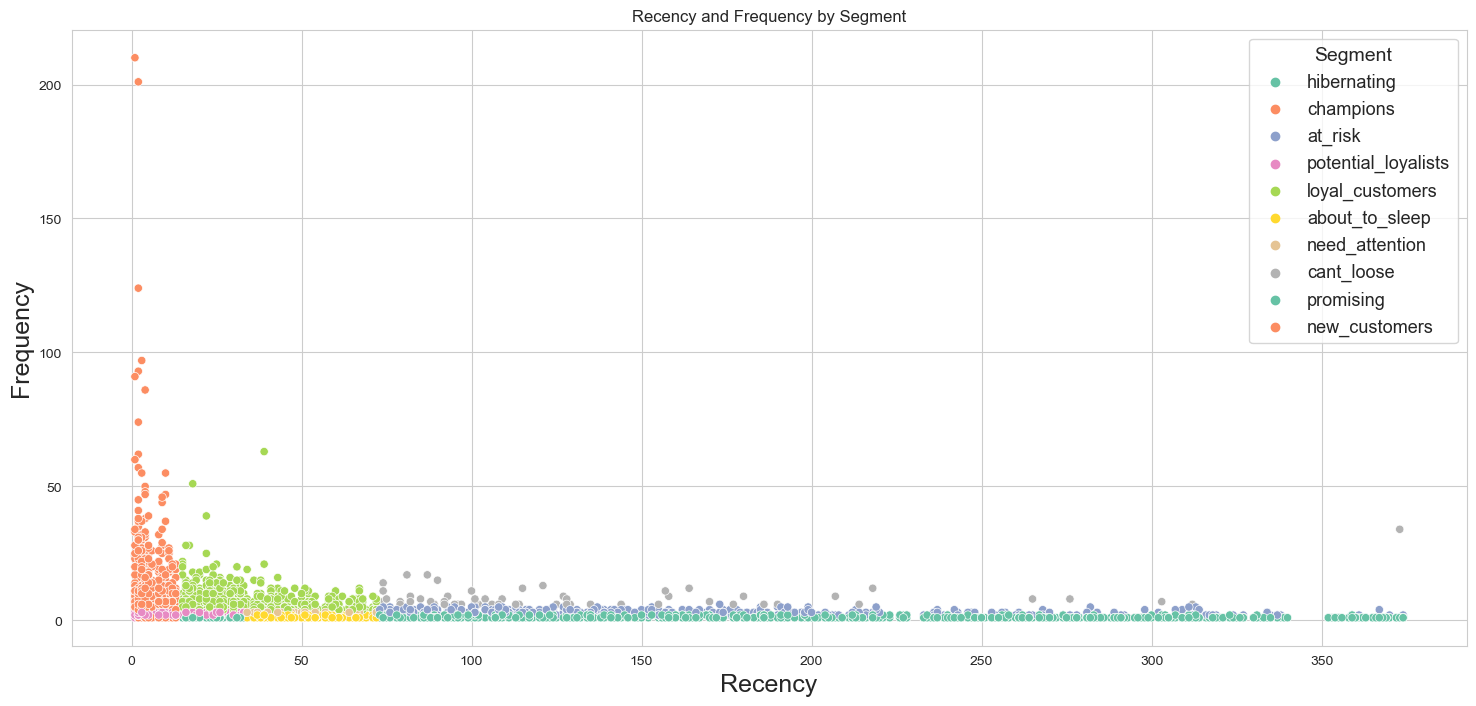

In [30]:
# 세그먼트별 recency, frequecy 의 스캐터 플롯을 그려본다.
plt.figure(figsize=(18, 8))
sns.scatterplot(data=rfm, x="recency", y="frequency", hue="segment", palette=palette)
plt.title("Recency and Frequency by Segment")
plt.xlabel("Recency", size=18)
plt.ylabel("Frequency", size=18)
plt.legend(loc="best", fontsize=13, title="Segment", title_fontsize=14)
plt.show()

이 플롯은 세그먼트별 그룹의 특성을 잘 보여주는데 champions, loyal customers 그룹이 더 자주 더 최근에 주문을 한다면 반대로 hibernating, at ristk 그룹은 이와 반대의 특성을 나타내고 있다.

# 6. Cohort Analysis

첫 주문을 한 달을 기준으로 고객의 리텐션을 계산한다. 리텐션은 월별로 계산하면 2010년 12월부터 2011년 12월까지 1년간을 계산한다.

In [19]:
df_ = df[["CustomerID", "InvoiceNo", "InvoiceDate"]].drop_duplicates()
df_

,CustomerID,InvoiceNo,InvoiceDate
0,17850,536365,2010-12-01 08:26:00
7,17850,536366,2010-12-01 08:28:00
9,13047,536367,2010-12-01 08:34:00
21,13047,536368,2010-12-01 08:34:00
25,13047,536369,2010-12-01 08:35:00
...,...,...,...
541865,13777,581583,2011-12-09 12:23:00
541867,13777,581584,2011-12-09 12:25:00
541869,15804,581585,2011-12-09 12:31:00
541890,13113,581586,2011-12-09 12:49:00


In [20]:
df_["cohort"] = df_.groupby("CustomerID")["InvoiceDate"].transform("min").dt.month
df_

,CustomerID,InvoiceNo,InvoiceDate,cohort
0,17850,536365,2010-12-01 08:26:00,12
7,17850,536366,2010-12-01 08:28:00,12
9,13047,536367,2010-12-01 08:34:00,12
21,13047,536368,2010-12-01 08:34:00,12
25,13047,536369,2010-12-01 08:35:00,12
...,...,...,...,...
541865,13777,581583,2011-12-09 12:23:00,12
541867,13777,581584,2011-12-09 12:25:00,12
541869,15804,581585,2011-12-09 12:31:00,5
541890,13113,581586,2011-12-09 12:49:00,12


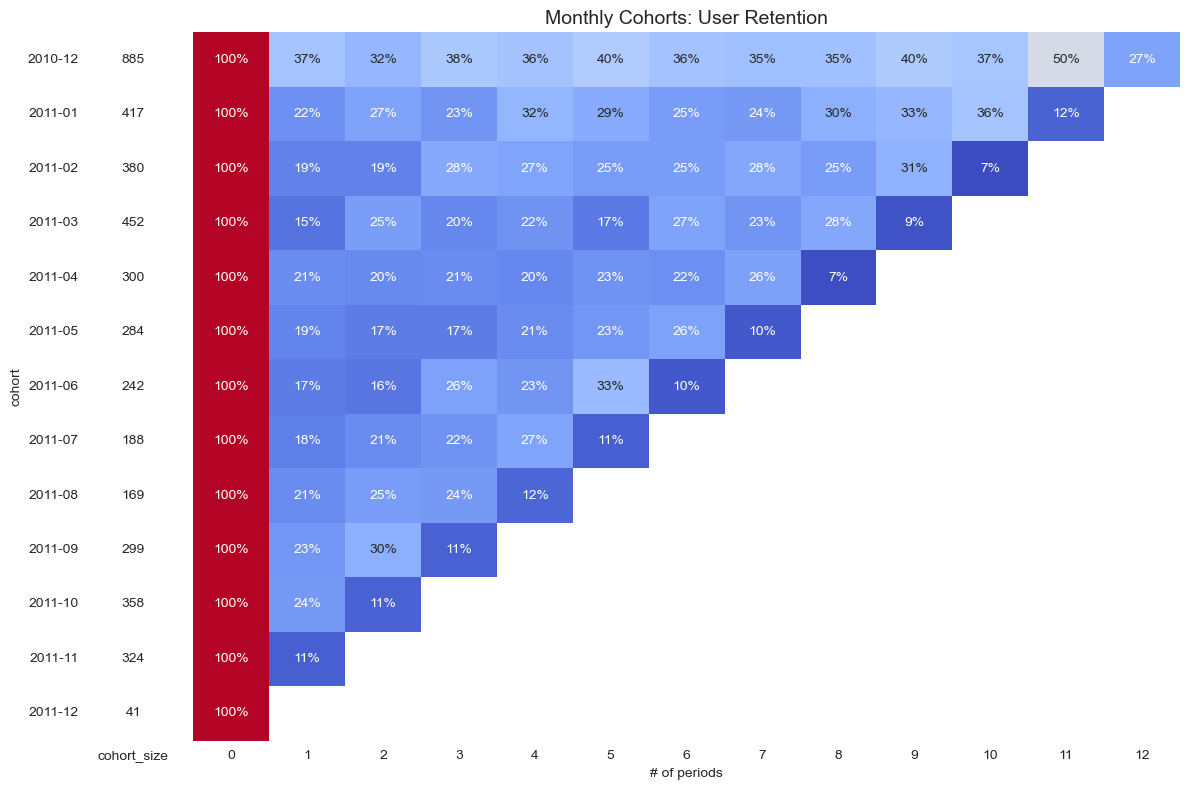

In [31]:
def CohortAnalysis(dataframe):
    # 우선 코호트 분석을 위한 표를 만든다.
    
    data = dataframe.copy()
    
    # CustomerID, InvoiceNo, InvoiceDate 열에 있는 중복값을 제거한다.
    
    data = data[["CustomerID", "InvoiceNo", "InvoiceDate"]].drop_duplicates()
    
    # 새로운 order_month 열을 만든다.
    data["order_month"] = data["InvoiceDate"].dt.to_period("M")
    
    # 고객의 구입한 가장 빠른 달을 기분으로 코호트를 만든다.
    data["cohort"] = (
        data.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M"))
    
    
    cohort_data = (
        data.groupby(["cohort", "order_month"])
        .agg(n_customers=("CustomerID", "nunique"))
        .reset_index(drop=False))
    
    cohort_data["period_number"] = (cohort_data.order_month - cohort_data.cohort).apply(
        attrgetter("n"))
    
    # 피봇 테이블을 만든다.
    cohort_pivot = cohort_data.pivot_table(
        index="cohort", columns="period_number", values="n_customers")
    
    # 코호트 그룹의 사이즈는 첫번째 구매월로 정한다.
    cohort_size = cohort_pivot.iloc[:, 0]

    # 고객의 월별 수는 코호트 사이즈 수로 나눈다.
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    
    # 월별 리텐션의 히트맵을 그린다.
    with sns.axes_style("white"):
        fig, ax = plt.subplots(
            1, 2, figsize=(12, 8), sharey=True, gridspec_kw={"width_ratios": [1, 11]}
        )
        sns.heatmap(
            retention_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            cbar=False,
            fmt=".0%",
            cmap="coolwarm",
            ax=ax[1],
        )
        ax[1].set_title("Monthly Cohorts: User Retention", fontsize=14)
        ax[1].set(xlabel="# of periods", ylabel="")
        white_cmap = mcolors.ListedColormap(["white"])
        sns.heatmap(
            pd.DataFrame(cohort_size).rename(columns={0: "cohort_size"}),
            annot=True,
            cbar=False,
            fmt="g",
            cmap=white_cmap,
            ax=ax[0],
        )
        fig.tight_layout()
    
CohortAnalysis(df)

# 7. Customer Lifetime Value

고객 생애 가치를 계산해 보는데, 고객 생애 가치는 고객의 전생애간 고객이 만들어 내는 금전적, 경제적 가치를 의미한다.

In [32]:
# 앞서 오늘의 날짜를 2011-12-11으로 설정하였다.
clv_df = df.groupby('CustomerID').agg({'InvoiceDate':[lambda x: (x.max() - x.min()).days, 
                                                      lambda x: (today_date - x.min()).days],
                                       'InvoiceNo': 'nunique', 'TotalPrice': 'sum'})
clv_df.columns = clv_df.columns.droplevel(0)

# T 는 고객의 생애를 의미한다.
clv_df.columns = ['recency', 'T', 'frequency', 'monetary']
clv_df.head()

,recency,T,frequency,monetary
CustomerID,,,,
12346,0,326,1,310.44
12347,365,368,7,4310.00
12348,282,359,4,1770.78
12349,0,19,1,1491.72
12350,0,311,1,331.46


In [33]:
# 주문건강 평균 가치를 구한다.

clv_df['avg_order_value'] = clv_df['monetary'] / clv_df['frequency']

# recency, tenure을 주단위로 계산한다.
clv_df['recency_week'] = clv_df['recency'] / 7
clv_df['T_week'] = clv_df['T'] / 7

# avg_order_value, recency_week, and T_week만 남기로 다른 열은 없앤다.
clv = clv_df.drop(['recency', 'T', 'monetary'], axis=1)

# frequency는 1보다 큰 값만 필터한다.
clv = clv[clv['frequency'] > 1]
clv

,frequency,avg_order_value,recency_week,T_week
CustomerID,,,,
12347,7,615.714286,52.142857,52.571429
12348,4,442.695000,40.285714,51.285714
12352,8,219.542500,37.142857,42.428571
12356,3,937.143333,43.142857,46.571429
12358,2,575.210000,21.285714,21.571429
...,...,...,...,...
18272,6,513.096667,34.857143,35.285714
18273,3,68.000000,36.428571,36.857143
18282,2,89.025000,16.857143,18.142857


### BG/NBD Models

Beta Geometric/Negative Binomial Distribution 모델은 감마 푼포를 따르는 주문 비율에 동질성이 있으며 주문건수가 푸아송 분포를 따르는 것을 전제로 한다. 이러한 제넌는 주문 건수에 대한 Negative Binomial Distribution (NBD) 모델을 가능하게 한다. BetaGeoFitter, lifetimes p패키지를 이용해 BG/NBD 모델을 적용한다.

In [34]:
# 오버피팅을 방지하기 위해 penalizer coefficient을 0.01로 설정한다.
BGF = BetaGeoFitter(penalizer_coef=0.01)

BGF.fit(clv['frequency'], clv['recency_week'], clv['T_week'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.06, alpha: 9.30, b: 1.13, r: 1.78>

### Top 10 Expected Number of Transactions (1 Week)

In [35]:
# 주별 예상 주문 건수를 계산하다.
BGF.conditional_expected_number_of_purchases_up_to_time(1, clv['frequency'], clv['recency_week'], 
                                                       clv['T_week']).sort_values(
    ascending=False).head(10).to_frame().reset_index()

,CustomerID,0
0,12748,3.371969
1,14911,3.228667
2,17841,2.001921
3,13089,1.586032
4,14606,1.508764
5,15311,1.477190
6,12971,1.399265
7,14646,1.260643
8,13408,1.014806
9,18102,0.996760


### Top 10 Expected Number of Transactions (1 Month)

In [36]:
# 월별 예상 주문건수 또한 계산한다.
BGF.conditional_expected_number_of_purchases_up_to_time(4, clv['frequency'], clv['recency_week'], 
                                                       clv['T_week']).sort_values(
    ascending=False).head(10).to_frame().reset_index()

,CustomerID,0
0,12748,13.469161
1,14911,12.896742
2,17841,7.996518
3,13089,6.335174
4,14606,6.026608
5,15311,5.900484
6,12971,5.589196
7,14646,5.035170
8,13408,4.053494
9,18102,3.981335


### Frequency of Repeat Transactions

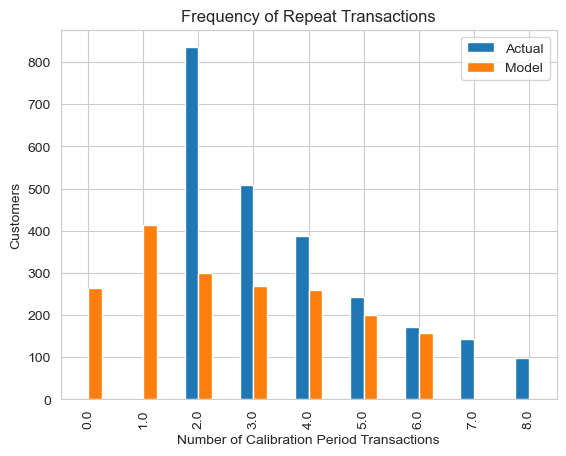

In [27]:
# 기간별 실제 주문건수와 예측 건수를 비교하는 플롯을 ㄱ
plot_period_transactions(BGF, max_frequency=7)
plt.show()